In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics
from src.config import get_config_from_stem

# Define path for the test dataset
data_stem="dialog-re-llama-11cls-rebalPairs6x-rwrtKeys-instrC-mxTrnCp3-shfflDt"
test_file_path = f"/home/murilo/RelNetCare/data/processed/{data_stem}/{data_stem}-test.json"

# get config and evaluator
config = get_config_from_stem(data_stem)
evaluator = RelationExtractorEvaluator(config=config)

# Evaluate performance
df = evaluator.assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
df.sort_values(['f1s', 'raw_inference'], ascending=[False, False])


/home/murilo/miniconda3/envs/llama-lora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-trToDial-rwrtKeys-instrA
output_dir= /home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-balPairs-rebalPairs-rwrtKeys-instrC-shfflDt



Script successfully executed!
Avg P: 16.1% | Avg R: 15.8% | Avg F1: 15.7% | Errors: 1/1562 (0%)
# INFERENCE REPORT
/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-rebalPairs5x-rwrtKeys-instrC-mxTrnCp3-shfflDt/dialog-re-llama-11cls-rebalPairs5x-rwrtKeys-instrC-mxTrnCp3-shfflDt-test_20230918_224939.xlsx



,id,prompt,raw_inference,true_labels,predicted_labels,correct_labels,wrong_labels,missing_labels,dialogue,f1s,precision,recall,error_message
1227,identity_215_006,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Paris"",\n ""subject_type""...",[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
89,identity_173_010,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...",[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
1352,identity_173_009,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...",[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
484,identity_82_008,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 4"",\n ""subject_t...",[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
650,identity_82_007,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 5"",\n ""subject_t...","[\n {\n ""subject"": ""Speaker 4"",\n ""subject_t...",[],[],Extract entities and relations from the dialog...,1.0,1.0,1.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,identity_92_006,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...","[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...","[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...",[],"[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...","[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...",Extract entities and relations from the dialog...,0.0,0.0,0.0,
1137,identity_55_001,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...","[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...","[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...",[],"[\n {\n ""subject"": ""Ben"",\n ""subject_type"": ...","[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",Extract entities and relations from the dialog...,0.0,0.0,0.0,
1057,identity_26_002,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,
1494,identity_26_000,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],"[\n {\n ""subject"": ""Barry"",\n ""subject_type""...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,


In [23]:
# mask = ((df.true_labels.astype(str) == "[]") &  (df.predicted_labels.astype(str) == "[]" ))
# mask.value_counts()

In [22]:
# mask = ( (df.predicted_labels.astype(str) == "[]" ))
# mask.value_counts()

predicted_labels
False    1382
Name: count, dtype: int64

In [25]:
# idx=0
# print(df.prompt.iloc[idx])
# print(df.raw_inference.iloc[idx])
# config.allowed_relations

mask = (df.predicted_labels.str.len() < 127)
df[mask]

,id,prompt,raw_inference,true_labels,predicted_labels,correct_labels,wrong_labels,missing_labels,dialogue,f1s,precision,recall,error_message
512,identity_16_004,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,
550,identity_36_032,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,
638,identity_36_034,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 1"",\n ""subject_t...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,
832,identity_115_000,Extract entities and relations from the dialog...,"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],"[\n {\n ""subject"": ""Speaker 2"",\n ""subject_t...",[],Extract entities and relations from the dialog...,0.0,0.0,0.0,


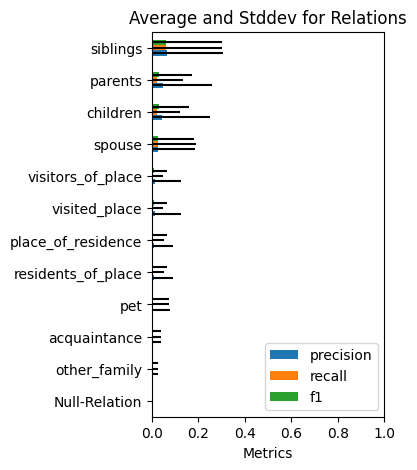

In [3]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics

# Define your ontology
your_ontology = {
    "Null-Relation", 
    "other_family", "siblings",
    "spouse", "pet", "acquaintance", "children",
    "parents",
    "visitors_of_place", "residents_of_place",  
    "visited_place", "place_of_residence",
    # "Attachment"
    # "title", "alternate_names", "place_of_work", "unanswerable"
    }

# your_ontology = list(config.allowed_relations)

# your_ontology = config.all_relations
# Usage
my_metrics = RelationGranularMetrics(df, your_ontology)
result = my_metrics.process()
chart_df = my_metrics.to_dataframe()
my_metrics.plot_metrics(chart_df, figsize=(3,5))
# my_metrics.plot_metrics(chart_df, figsize=(4,12))


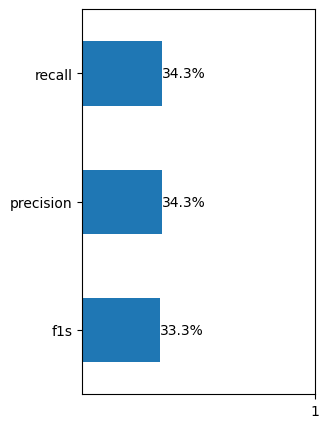

In [16]:
import matplotlib.pyplot as plt

# Your plotting code here
ax = df[['f1s', 'precision', 'recall']].mean().plot(kind='barh', alpha=1, figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])

# Adding data values on top of each bar
for bar in ax.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1%}', 
             va='center', ha='left')

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

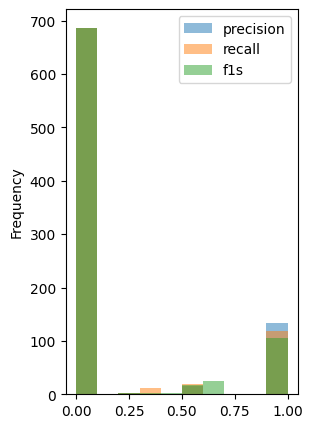

In [6]:
df[['precision', 'recall', 'f1s']].fillna(0).plot(kind='hist', alpha=0.5, figsize=(3, 5))


In [204]:
print(config.preprompt)

Extract entities and relations from the dialogue. Return a Python list of JSON objects, each fitting this schema: {"subject": "<Entity>", "subject_type": "<Animal/Organization/Location/Person/Date/Event>", "relation": "<acquaintance/children/other_family/parents/pet/place_of_residence/residents_of_place/siblings/spouse/visited_place/visitors_of_place>", "object": "<Related Entity>", "object_type": "<Animal/Organization/Location/Person/Date/Event>"}. No additional text or explanations. Return an empty list if no relevant entities or relations are found. Stick to the provided types and relations. You are like an API, you don't speak you only return JSON objects.
Dialogue: {input_dialogue}


In [9]:
dialogue = 'Speaker 1: Hi, you are my father.\nSpeaker 2: Yes, I am your father'
# dialogue = 'Speaker 1: I went to Maryland.\nSpeaker 2: Why?\nSpeaker 1: I work at Google there.'
# dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! What is his name?\nSpeaker 1: John.'
# dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! '
jsonl = evaluator.infer_from_model(dialogue, preprompt=config.preprompt)
print(dialogue)

try:
    print(jsonl.replace('},', '},\n'))
except Exception as e:
    print(f'Exception={e}')
    print(jsonl)

Speaker 1: Hi, you are my father.
Speaker 2: Yes, I am your father

Extract personal relevant entities, and their relations. Return only the jsonl format list. Extract entities and relations from the given dialogue input and generate a JSON list as output that is structured according to the entity and relation types from the ontology.

Ontology: 
- relations: {"place_of_residence", "siblings", "residents_of_place", "visited_place", "visitors_of_place", "other_family", "parents", "pet", "acquaintance", "children", "spouse"}
- types: {"ORG", "GPE", "PERSON", "DATE", "EVENT", “ANIMAL”}

Input:
[
"Speaker 1: Hi, you are my father.",
"Speaker 2: Yes, I am your father",
]

Output:
[
{"subject": "Speaker 1", "subject_type": "PERSON", "relation": "siblings", "object": "Speaker 2", "object_type": "PERSON"},

{"subject": "Speaker 2", "subject_type": "PERSON", "relation": "siblings", "object": "Speaker 1", "object_type": "PERSON"},

{"subject": "Speaker 1", "subject_type": "PERSON", "relation": "